<a href="https://colab.research.google.com/github/omdena/earthquake/blob/master/Demo_Raster_Heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install packages and Retrieve data

In [0]:
import os
os.system('pip install geopandas ;apt install libspatialindex-dev; pip install rtree;pip install rasterio; pip install osmnx; pip install PyCRS')
import networkx as nx
import osmnx as ox
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from shapely.ops import cascaded_union
from shapely.geometry import Point, Polygon
from rasterio.plot import show
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
from fiona.crs import from_epsg
import pycrs
%matplotlib inline

In [3]:
### Elevation data from SRTM Digital Elevation Data for region around the Bosphorus
!wget -O srtm_42_04.zip http://srtm.csi.cgiar.org/wp-content/uploads/files/srtm_5x5/TIFF/srtm_42_04.zip
!unzip srtm_42_04.zip
!ls -l

--2019-12-14 11:20:04--  http://srtm.csi.cgiar.org/wp-content/uploads/files/srtm_5x5/TIFF/srtm_42_04.zip
Resolving srtm.csi.cgiar.org (srtm.csi.cgiar.org)... 45.5.184.44
Connecting to srtm.csi.cgiar.org (srtm.csi.cgiar.org)|45.5.184.44|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://srtm.csi.cgiar.org/wp-content/uploads/files/srtm_5x5/tiff/srtm_42_04.zip [following]
--2019-12-14 11:20:05--  http://srtm.csi.cgiar.org/wp-content/uploads/files/srtm_5x5/tiff/srtm_42_04.zip
Reusing existing connection to srtm.csi.cgiar.org:80.
HTTP request sent, awaiting response... 200 OK
Length: 21230587 (20M) [application/x-zip-compressed]
Saving to: ‘srtm_42_04.zip’

srtm_42_04.zip      100%[===================>]  20.25M  4.74MB/s    in 5.0s    

2019-12-14 11:20:10 (4.05 MB/s) - ‘srtm_42_04.zip’ saved [21230587/21230587]

Archive:  srtm_42_04.zip
  inflating: readme.txt              
  inflating: srtm_42_04.hdr          
  inflating: srtm_42_04.tfw      

## Working with GeoTiff files (.tif files)

### Ingest Raster/Pixel file

In [27]:
## Ingest the raster file with rasterio module
fp = "srtm_42_04.tif"
# Open the file:
raster = rasterio.open(fp)
## Cannot show raster right now because the file is huge,
## but it's possible to make small cuts to fit an area we need.
print('Data type:\n', type(raster))
print('Metadata:\n', raster.meta)

## Alternatively, you can use .read() method to get data as numpy array
print('\nNumpy Arrays:\n')
print(raster.read().shape)
print(raster.read())

Data type:
 <class 'rasterio.io.DatasetReader'>
Metadata:
 {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 6000, 'height': 6000, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0008333333333333334, 0.0, 25.0,
       0.0, -0.0008333333333333334, 45.0)}

Numpy Arrays:

(1, 6000, 6000)
[[[   400    400    414 ...      0      0      0]
  [   394    406    425 ...      0      0      0]
  [   395    418    435 ...      0      0      0]
  ...
  [-32768 -32768 -32768 ...    707    710    721]
  [-32768 -32768 -32768 ...    720    728    740]
  [-32768 -32768 -32768 ...    741    745    745]]]


### Define boundary of clipping/cropping

In [11]:
%matplotlib inline
## Retrieve the vector boundary of the area we need
place_name = 'Fatih, Istanbul, Turkey'
area = ox.gdf_from_place(place_name, buffer_dist= 50)
geo = area.to_crs(crs=raster.crs.data)

## transform vector boundary to GeoJSON compatible with rasterio
def getFeatures(gdf):
  """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
  import json
  return [json.loads(gdf.to_json())['features'][0]['geometry']]

coords = getFeatures(geo)
print('Area of Interest:\n', coords)

## Clip the raster with GeoJSON boundary above
out_img, out_transform = mask(raster, shapes=coords, crop=True)



## Parse EPSG code which is a WorldWide standard for coordinate system. Google it!
epsg_code = int(raster.crs.data['init'][5:])
print(epsg_code)
## make copy meta data of raster file for safe editing 
out_meta = raster.meta.copy()
out_meta.update({"driver": "GTiff",
                  "height": out_img.shape[1],
                  "width": out_img.shape[2],
                  "transform": out_transform,
                  "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


Area of Interest:
 [{'type': 'Polygon', 'coordinates': [[[28.91842171261524, 40.988264461311665], [28.918425610208843, 40.98853256138479], [28.91842729331257, 40.98856182735239], [28.91847252440902, 40.98901141307551], [28.918523505033733, 40.98976706002396], [28.918519492594378, 40.99005901283013], [28.918519469843858, 40.990061159778236], [28.91851486428834, 40.99067935987755], [28.918520012667432, 40.99074109762669], [28.918638506790522, 40.991418098356995], [28.918652069935522, 40.99147103097174], [28.918770267150624, 40.99181933161837], [28.91878339822286, 40.9918526377943], [28.918799881103787, 40.991885077199875], [28.918932111084157, 40.99211806634134], [28.919190999769906, 40.99264128639427], [28.919976846781307, 40.9943777704476], [28.92016507043301, 40.99518947004936], [28.920159264908985, 40.99585107513772], [28.920072401055236, 40.996355725974766], [28.919890751541864, 40.997043445818306], [28.919889756315314, 40.99704730100326], [28.919638156205597, 40.99804498705745], [2

### export result and re-ingest for inspection

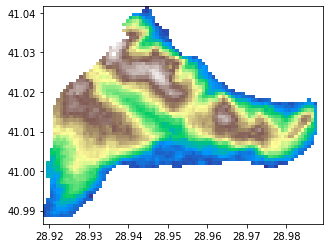

In [74]:
## Finally, save clipped/cropped raster file.
with rasterio.open('out.tif', "w+", **out_meta) as dest:
  dest.write(out_img)
 
## Ingest and show the rasterio shortcut
clipped = rasterio.open('out.tif')
show((clipped), cmap='terrain')
plt.show()


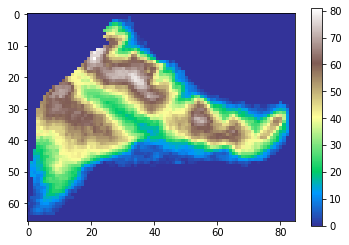

In [73]:
## The manual numpy way
max_ref = np.amax(np.amax(clipped.read()[0,:,:]))

ax = plt.imshow(clipped.read()[0,:,:], cmap='terrain')
ax.set_clim(vmin=0, vmax=max_ref)
# Add colorbar to show the index
plt.colorbar()